In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier


In [2]:
titanic_train = pd.read_csv('data/train.csv')
titanic_test = pd.read_csv('data/test.csv')


In [3]:
titanic_train


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Step 1: Handling data before applying DataMining Features

#### 1.1 Drop Columns with no relevant inforamtion

we dropped the follwing:

- PassengerId : useless numbering of passengers
- Name : String value that has no effect
- Ticket : String value that has no effect
- Cabin : String value that has no effect


In [4]:
titanic_train.drop(columns=['PassengerId', 'Name',
                   'Ticket', 'Cabin'], inplace=True)


#### 1.2 Dropping rows with NaN values

the reason: Features in this DataBase are too important to auto-fill


In [5]:
for col in titanic_train.columns:
    titanic_train.dropna(inplace=True)


In [6]:
titanic_train


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
889,1,1,male,26.0,0,0,30.0000,C


#### 1.3 Binning Sex attribute

- male : {0}
- female : {1}


In [7]:
titanic_train['Sex'] = titanic_train['Sex'].map({'male': 0, 'female': 1})
titanic_train


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,1,39.0,0,5,29.1250,Q
886,0,2,0,27.0,0,0,13.0000,S
887,1,1,1,19.0,0,0,30.0000,S
889,1,1,0,26.0,0,0,30.0000,C


#### 1.4 converting the categorical feature 'Embarked' into numerical labels


In [8]:
label_encoder = LabelEncoder()
titanic_train['Embarked'] = label_encoder.fit_transform(
    titanic_train['Embarked'])


In [9]:
titanic_train


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2
1,1,1,1,38.0,1,0,71.2833,0
2,1,3,1,26.0,0,0,7.9250,2
3,1,1,1,35.0,1,0,53.1000,2
4,0,3,0,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
885,0,3,1,39.0,0,5,29.1250,1
886,0,2,0,27.0,0,0,13.0000,2
887,1,1,1,19.0,0,0,30.0000,2
889,1,1,0,26.0,0,0,30.0000,0


### Step 2: Pre-Processing


#### 2.1: Normalization

using MinMaxScaler function


In [10]:
titanic_train_copy = copy.deepcopy(titanic_train)
titanic_test_copy = copy.deepcopy(titanic_test)

numerical_cols = titanic_train.columns.drop('Survived')


norm_scaler = MinMaxScaler()
titanic_train_copy[numerical_cols] = norm_scaler.fit_transform(
    titanic_train_copy[numerical_cols])

titanic_train_copy


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1.0,0.0,0.271174,0.2,0.000000,0.014151,1.0
1,1,0.0,1.0,0.472229,0.2,0.000000,0.139136,0.0
2,1,1.0,1.0,0.321438,0.0,0.000000,0.015469,1.0
3,1,0.0,1.0,0.434531,0.2,0.000000,0.103644,1.0
4,0,1.0,0.0,0.434531,0.0,0.000000,0.015713,1.0
...,...,...,...,...,...,...,...,...
885,0,1.0,1.0,0.484795,0.0,0.833333,0.056848,0.5
886,0,0.5,0.0,0.334004,0.0,0.000000,0.025374,1.0
887,1,0.0,1.0,0.233476,0.0,0.000000,0.058556,1.0
889,1,0.0,0.0,0.321438,0.0,0.000000,0.058556,0.0


#### 2.2 Standarization

using StandardScaler function


In [11]:
scaler_std = StandardScaler()
titanic_train_copy[numerical_cols] = scaler_std.fit_transform(
    titanic_train_copy[numerical_cols])

titanic_train_copy


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,0.908600,-0.756138,-0.527669,0.522511,-0.506787,-0.516380,0.519588
1,1,-1.482983,1.322511,0.577094,0.522511,-0.506787,0.694046,-2.049487
2,1,0.908600,1.322511,-0.251478,-0.552714,-0.506787,-0.503620,0.519588
3,1,-1.482983,1.322511,0.369951,0.522511,-0.506787,0.350326,0.519588
4,0,0.908600,-0.756138,0.369951,-0.552714,-0.506787,-0.501257,0.519588
...,...,...,...,...,...,...,...,...
885,0,0.908600,1.322511,0.646142,-0.552714,5.350885,-0.102875,-0.764949
886,0,-0.287191,-0.756138,-0.182430,-0.552714,-0.506787,-0.407687,0.519588
887,1,-1.482983,1.322511,-0.734812,-0.552714,-0.506787,-0.086335,0.519588
889,1,-1.482983,-0.756138,-0.251478,-0.552714,-0.506787,-0.086335,-2.049487


### Step 3: Selection Features - Recursive feature selection


#### 3.1: LogisticRegression


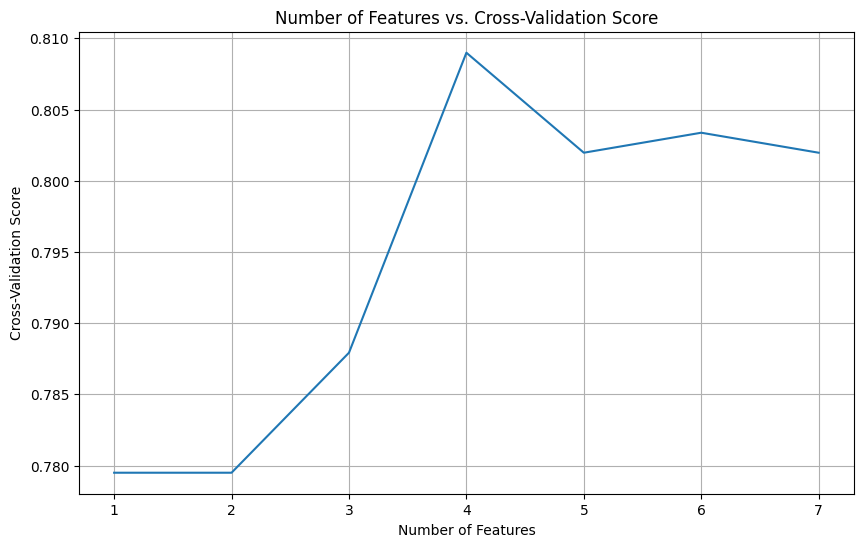

Optimal number of features: 4
Selected features: Index(['Pclass', 'Sex', 'Age', 'SibSp'], dtype='object')


In [12]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


X = titanic_train_copy.drop(columns=['Survived'])
y = titanic_train_copy['Survived']

number_of_features = range(1, len(X.columns) + 1)
estimator = LogisticRegression()
scores = []
selected_features_list = []


for i in number_of_features:
    rfe = RFE(estimator, n_features_to_select=i)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]
    selected_features_list.append(selected_features)
    scores.append(rfe.score(X, y))


plt.figure(figsize=(10, 6))
plt.plot(number_of_features, scores)
plt.title('Number of Features vs. Cross-Validation Score')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Score')
plt.xticks(number_of_features)
plt.grid(True)
plt.show()

best_index = scores.index(max(scores))
best_num_features = number_of_features[best_index]
best_selected_features = selected_features_list[best_index]

print("Optimal number of features:", best_num_features)
print("Selected features:", best_selected_features)


#### 3.2 Random Forest Classifier


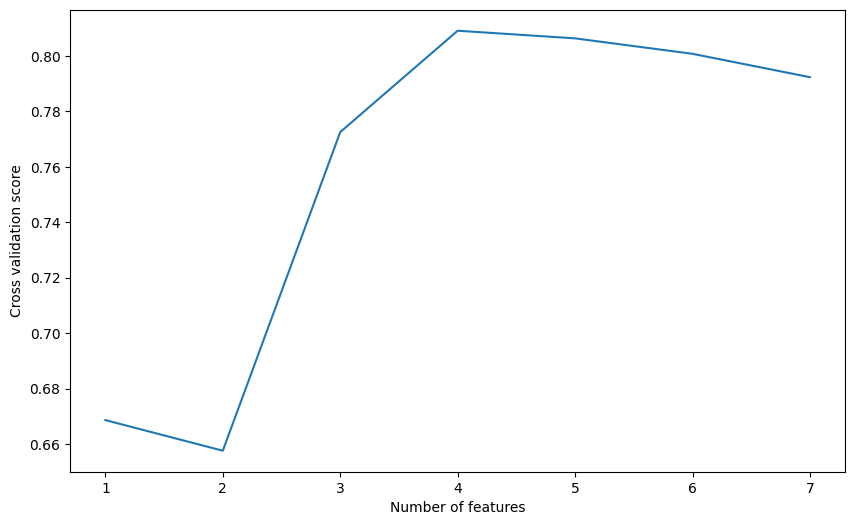

Optimal number of features: 4
Selected features: Index(['Pclass', 'Sex', 'Age', 'Fare'], dtype='object')


In [13]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

X = titanic_train_copy.drop(columns=['Survived'])
y = titanic_train_copy['Survived']


estimator = RandomForestClassifier(n_estimators=100)
rfecv = RFECV(estimator=estimator, step=1,
              cv=StratifiedKFold(10), scoring='accuracy')

rfecv.fit(X, y)


plt.figure(figsize=(10, 6))
plt.xlabel("Number of features")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_[
         'mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

print("Optimal number of features: {}".format(rfecv.n_features_))
selected_features = X.columns[rfecv.support_]
print("Selected features:", selected_features)
